In [1]:
# import cell
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import sklearn

In [2]:
#Datasets - loading in dataframes
games_df = pd.read_csv("/work/games.csv")
games_details_df = pd.read_csv("/work/games_details.csv")
players_df = pd.read_csv("/work/players.csv")
ranking_df = pd.read_csv("/work/ranking.csv")
teams_df = pd.read_csv("/work/teams.csv")

/shared-libs/python3.9/py-core/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3139: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


# General EDA (relevant to both questions)

In [3]:
#------------------df copies--------------------
eda_games_df = games_df.copy()
eda_games_details_df = games_details_df.copy()

#--------------DROP UNNECESSARY COLUMNS--------------
eda_games_df.drop(eda_games_df.columns.difference(['GAME_DATE_EST','GAME_ID', 'SEASON']), axis=1, inplace=True)
eda_games_details_df.drop(columns=['TEAM_ABBREVIATION', 'TEAM_CITY','NICKNAME','START_POSITION', 'COMMENT'], axis=1, inplace=True)

#-----------------FIND IF FIRST OR SECOND HALF---------------------
eda_games_df['GAME_DATE_EST'] = pd.to_datetime(eda_games_df['GAME_DATE_EST'])

#------------------MERGE GAMES_DF and GAME_DETAILS--------------------
eda_games_merged_df = pd.merge(eda_games_details_df, eda_games_df, on='GAME_ID', how='inner')

# Here we split the games into first and second half of seasons roughly
split_Training = eda_games_merged_df[eda_games_merged_df['GAME_DATE_EST'].dt.month > 6][eda_games_merged_df['GAME_DATE_EST'].dt.year == 2021]
split_Test = eda_games_merged_df[eda_games_merged_df['GAME_DATE_EST'].dt.month < 6][eda_games_merged_df['GAME_DATE_EST'].dt.year == 2022]

len(split_Training), len(split_Test)

/tmp/ipykernel_146/1278335821.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  split_Training = eda_games_merged_df[eda_games_merged_df['GAME_DATE_EST'].dt.month > 6][eda_games_merged_df['GAME_DATE_EST'].dt.year == 2021]
/tmp/ipykernel_146/1278335821.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  split_Test = eda_games_merged_df[eda_games_merged_df['GAME_DATE_EST'].dt.month < 6][eda_games_merged_df['GAME_DATE_EST'].dt.year == 2022]


(16395, 20011)

In [4]:
def convert_to_seconds(time_val):
    if isinstance(time_val, str):  # Check if the value is a string
        minutes, seconds = time_val.split(':')
        return float(minutes) * 60 + float(seconds)
    else:
        return float('nan')  # or return 0 or any other default value

# Apply the function to the DataFrame column to convert MIN
split_Training_cleaned = split_Training.dropna(subset=['MIN'])
split_Training_cleaned['MIN'] = split_Training_cleaned['MIN'].astype('str')
split_Training_cleaned['MIN'] =  split_Training_cleaned['MIN'].apply(convert_to_seconds)
print(split_Training_cleaned.head())

# We group by player and apply mean grouping to get average statistics per game
split_Training_cleaned = split_Training_cleaned.groupby("PLAYER_NAME").mean().reset_index()
split_Training_cleaned["MIN"] = split_Training_cleaned["MIN"].astype(int)
split_Training_cleaned.head()
#plt.scatter(split_Training['PLAYER_NAME'], split_Training['FG_PCT'])

/tmp/ipykernel_146/2853061690.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  split_Training_cleaned['MIN'] = split_Training_cleaned['MIN'].astype('str')
/tmp/ipykernel_146/2853061690.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  split_Training_cleaned['MIN'] =  split_Training_cleaned['MIN'].apply(convert_to_seconds)
        GAME_ID     TEAM_ID  PLAYER_ID      PLAYER_NAME     MIN  FGM   FGA  \
34839  22100529  1610612756    1628969    Mikal Bridges  1758.0  4.0  11.0   
34840  22100529  16106127

,PLAYER_NAME,GAME_ID,TEAM_ID,PLAYER_ID,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,...,DREB,REB,AST,STL,BLK,TO,PF,PTS,PLUS_MINUS,SEASON
0,A.J. Lawson,1.210000e+07,1.610613e+09,1630639.0,415,2.000000,3.000000,0.667000,2.000000,2.000000,...,2.000000,2.000000,0.000000,0.000000,0.000000,1.000000,0.000000,8.000000,-6.000000,2021.0
1,Aamir Simms,1.210003e+07,1.610613e+09,1630603.0,409,0.500000,1.000000,0.500000,0.000000,0.000000,...,1.000000,2.500000,1.000000,0.000000,0.000000,0.000000,1.000000,2.000000,3.000000,2021.0
2,Aaron Gordon,2.092374e+07,1.610613e+09,203932.0,1878,5.058824,10.058824,0.511294,1.029412,3.000000,...,3.705882,5.352941,2.294118,0.558824,0.647059,1.441176,1.882353,13.470588,3.735294,2021.0
3,Aaron Henry,1.638587e+07,1.610613e+09,1630565.0,524,0.571429,2.000000,0.133286,0.142857,0.714286,...,0.857143,1.000000,0.571429,1.000000,0.285714,0.571429,0.857143,1.428571,-0.857143,2021.0
4,Aaron Holiday,2.098911e+07,1.610613e+09,1628988.0,1008,2.694444,5.583333,0.489417,0.611111,1.638889,...,1.694444,1.861111,1.888889,0.583333,0.222222,1.055556,1.638889,6.694444,-2.527778,2021.0


In [5]:
def convert_to_seconds(time_val):
    if isinstance(time_val, str):  # Check if the value is a string
        minutes, seconds = time_val.split(':')
        return float(minutes) * 60 + float(seconds)
    else:
        return float('nan')  # or return 0 or any other default value

# Apply the function to the DataFrame column to convert MIN
split_Test_cleaned = split_Test.dropna(subset=['MIN'])
split_Test_cleaned['MIN'] = split_Test_cleaned['MIN'].astype('str')
split_Test_cleaned['MIN'] =  split_Test_cleaned['MIN'].apply(convert_to_seconds)
print(split_Test_cleaned.head())

# We group by player and apply mean grouping to get average statistics per game
split_Test_cleaned = split_Test_cleaned.groupby("PLAYER_NAME").mean().reset_index()
split_Test_cleaned["MIN"] = split_Test_cleaned["MIN"].astype(int)
split_Test_cleaned.head()
#plt.scatter(split_Training['PLAYER_NAME'], split_Training['FG_PCT'])

        GAME_ID     TEAM_ID  PLAYER_ID          PLAYER_NAME     MIN  FGM  \
14828  42100307  1610612738    1628369         Jayson Tatum  2734.0  9.0   
14829  42100307  1610612738     201143           Al Horford  2642.0  2.0   
14830  42100307  1610612738    1629057  Robert Williams III   882.0  0.0   
14831  42100307  1610612738    1627759         Jaylen Brown  2618.0  8.0   
14832  42100307  1610612738     203935         Marcus Smart  2445.0  8.0   

        FGA  FG_PCT  FG3M  FG3A  ...   REB  AST  STL  BLK   TO   PF   PTS  \
14828  21.0   0.429   4.0   7.0  ...  10.0  6.0  1.0  2.0  2.0  4.0  26.0   
14829   9.0   0.222   1.0   6.0  ...  14.0  3.0  1.0  2.0  0.0  4.0   5.0   
14830   2.0   0.000   0.0   0.0  ...   3.0  1.0  0.0  0.0  1.0  2.0   2.0   
14831  15.0   0.533   1.0   5.0  ...   6.0  6.0  0.0  0.0  4.0  5.0  24.0   
14832  22.0   0.364   3.0  10.0  ...   9.0  5.0  2.0  0.0  1.0  4.0  24.0   

       PLUS_MINUS  GAME_DATE_EST  SEASON  
14828         7.0     2022-05-29    2

,PLAYER_NAME,GAME_ID,TEAM_ID,PLAYER_ID,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,...,DREB,REB,AST,STL,BLK,TO,PF,PTS,PLUS_MINUS,SEASON
0,Aaron Gordon,2.410079e+07,1.610613e+09,203932.0,1879,5.940000,11.560000,0.510740,1.180000,3.700000,...,4.420000,6.200000,2.660000,0.560000,0.580000,1.860000,2.080000,15.480000,3.920000,2021.0
1,Aaron Henry,2.210062e+07,1.610613e+09,1630565.0,137,0.333333,1.000000,0.166667,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.333333,0.333333,0.333333,0.666667,-4.333333,2021.0
2,Aaron Holiday,2.534406e+07,1.610613e+09,1628988.0,814,2.054054,4.810811,0.446243,0.675676,1.567568,...,1.378378,2.000000,2.810811,0.729730,0.054054,1.000000,1.135135,5.864865,1.594595,2021.0
3,Aaron Nesmith,2.781499e+07,1.610613e+09,1630174.0,541,1.200000,2.914286,0.286029,0.485714,1.714286,...,1.257143,1.571429,0.371429,0.371429,0.228571,0.428571,1.057143,3.285714,1.542857,2021.0
4,Aaron Wiggins,2.210086e+07,1.610613e+09,1630598.0,1611,3.484848,7.969697,0.419667,0.878788,3.030303,...,2.727273,4.000000,1.545455,0.636364,0.181818,1.242424,1.939394,9.181818,-7.090909,2021.0


In [6]:
split_Training_cleaned_Visual = split_Training_cleaned[split_Training_cleaned["MIN"] > 1440]
split_Training_sorted_min = split_Training_cleaned_Visual.sort_values("MIN")

split_Test_cleaned_Visual = split_Test_cleaned[split_Test_cleaned["MIN"] > 1440]
split_Test_sorted_min = split_Test_cleaned_Visual.sort_values("MIN")

# Research Question 1 

Initial Research Question: Based on a player's in-game performance metrics and team context in the first half of the NBA season, can we predict the likelihood of them achieving specific performance benchmarks in the second half?

Updated Research Question: How can a decade of first-half performance data in the NBA be analyzed to forecast a team's probability of making the playoffs for the current season?

## Quantitative Visualization #1

Average field goal percentage in first half of season: 0.38983185927250974
Average field goal percentage in second half of season: 0.39751025265457496


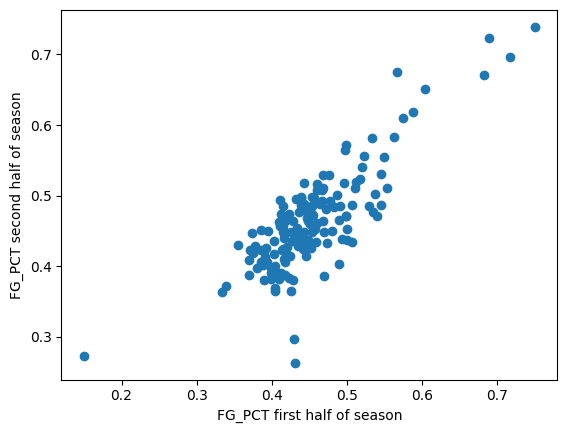

In [7]:
# let's find out the average field goal percentage in the first half of the season
average_fg_pct_first = np.mean(split_Training_cleaned['FG_PCT'])
# and the average field goal percentage in the second half of the season
average_fg_pct_second = np.mean(split_Test_cleaned['FG_PCT'])

print("Average field goal percentage in first half of season:", average_fg_pct_first)
print("Average field goal percentage in second half of season:", average_fg_pct_second)

test = split_Training_sorted_min.merge(split_Test_sorted_min, how = 'inner', on = 'PLAYER_ID')
plt.xlabel('FG_PCT first half of season')
plt.ylabel('FG_PCT second half of season')
plt.scatter(test['FG_PCT_x'], test['FG_PCT_y'])

## Quantitative Visualization #2

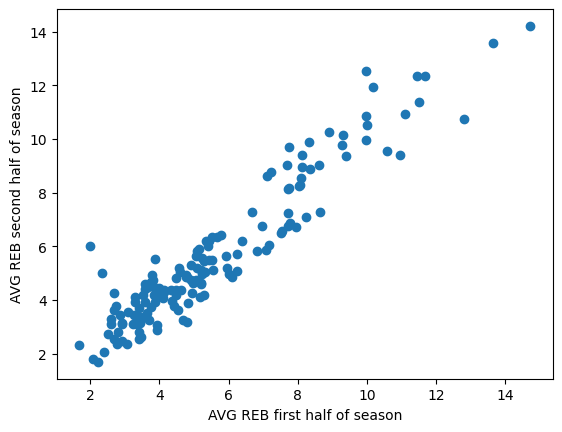

In [8]:
plt.xlabel('AVG REB first half of season')
plt.ylabel('AVG REB second half of season')
plt.scatter(test['REB_x'], test['REB_y'])

### How Visualizations are relevant to Research Question

We see a linear relationship here similar to the relationship for FG_PCT. While we mainly intend to use FG percentage as our indicator of performance, other performance metrics might also be valuable in our model so this graph is helping us explore rebounds as a possible indicator of performance. This connects to our first research question where we are predicting performance in second half of season based on first half. This graph indicates we could also use rebounds as part of our performance defintion and a linear model might work well for this as well.

# Option C: Prediction with GLMs and nonparametric methods

### Frequentist GLM 

Initially, we proposed two different methods to achieve this but we decided to focus on predictions with GLMs/nonparametric methods. 

For all three of the following models, we used only one parameter to predict the outcome. The reason for this is that we want to understand how a specific aspect of a player's performance (i.e. rebounds or FG percentage) in the first half of the season affects their performance in the second half. If we introduce multiple parameters, this clear relationship can become more easily obscured. We are open to adding more parameters in the final draft but for now we would like to understand these relationships between variables with the model rather than simply predict accurately.

Our first attempt at this uses the frequentist method of the GLM with Poisson as the family as the FG PCT column values are non-negative. We begin by defining performance as FG percentage (percent of shots made). So the first model is attempting to predict FG percentage in the second half of the season using FG percentage in the first half of the season. We think the feature (FG percentage in the first half of season) is valid to predict FG percentage in the second half of the season because generally unless an injury occurs or the team dynamic drastically shifts a player is expected to play pretty similarly throughout the season on average. Across dozens of players, there may be some who experience extraordinary circumstances that can cause this but on average we expect some consistency especially given our EDA visualizations which seemed to confirm a positive correlation between FG percentage in the first half of the season and FG percentage in the second half.

### Frequentist Model 1

In [9]:
!pip install statsmodels==0.14.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 65.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.9/233.9 kB 35.8 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [10]:
import statsmodels.api as sm

In [11]:
freq_model = sm.GLM(test['FG_PCT_y'], exog = sm.add_constant(test['FG_PCT_x']), 
                  family=sm.families.Poisson())
freq_res = freq_model.fit()
print(freq_res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:               FG_PCT_y   No. Observations:                  155
Model:                            GLM   Df Residuals:                      153
Model Family:                 Poisson   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -108.00
Date:                Tue, 12 Dec 2023   Deviance:                      0.54138
Time:                        03:09:29   Pearson chi2:                    0.523
No. Iterations:                     3   Pseudo R-squ. (CS):           0.007331
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.5620      0.740     -2.112      0.0

According to the frequentist GLM with Poisson Regression, with a p-value of 0.05, first half FG PCT is not a significant predictor of second half FG PCT. This is evident as the for an increase of 1 in REB_x, Y changes by  e^1.7313=5.64799152693 which is significant. Furthermore, the avg log-likelihood -108/153  is close to 0 which is an indicator that it is a good model. This is our 95% confidence interval for FG PCT: [-1.367, 4.829] and our 95% confidence interval contains 0, hence based on that we can interpret that there is no statistical significance of our model.

Let's try with a different independent/dependent variable. Now we will define performance by rebounds and see if rebounds in the first half of the season can predict rebounds in the second half using the same type of model. We think this feature (rebounds in the first half of season) is valid to predict rebounds in the second half of the season because generally unless an injury occurs or the team dynamic drastically shifts a player is expected to play pretty similarly throughout the season on average. There could be similar issues like the ones discussed in the previous model. However, our EDA visualizations revealed a positive correlation between rebounds in the first half of the season and rebounds in the second half. 

### Frequentist Model 2

In [12]:
# Rebounds in first half to predict rebounds in second half
freq_model_2 = sm.GLM(test['REB_y'], exog = sm.add_constant(test['REB_x']), 
                  family=sm.families.Poisson())
freq_res_2 = freq_model_2.fit()
print(freq_res_2.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  REB_y   No. Observations:                  155
Model:                            GLM   Df Residuals:                      153
Model Family:                 Poisson   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -284.98
Date:                Tue, 12 Dec 2023   Deviance:                       26.921
Time:                        03:09:29   Pearson chi2:                     27.0
No. Iterations:                     4   Pseudo R-squ. (CS):             0.6219
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8677      0.081     10.758      0.0

We see that using Poisson regression, our GLM results show that rebounds in the first half are a great predictor of rebounds in the second half. This is evident as the for an increase of 1 in REB_x, Y changes by  e^0.1417=1.1522309274 which is significant. Furthermore, the avg log-likelihood -284.98/153  is close to 0 which is an indicator that it is a good model. In this case, the 95% confidence interval is [0.120 0.163] which does not contain the null value (0), hence this model is statistically significant. 

Now we will consider combining these two performance metrics. We will attempt to use rebounds in the first half of the season to predict FG percentage in the second half of the season using the same GLM model. While these metrics are different, we believe there is a lot of overlap as far as player performance is concerned. If a player rebounds more they likely have more attempts to shoot themselves and to get the ball back to their team, these result in more chances to shoot and could lead to a higher FG percentage.

### Frequentist Model 3

In [13]:
# rebounds to predict FG_PCT?
freq_model_3 = sm.GLM(test['FG_PCT_y'], exog = sm.add_constant(test['REB_x']), 
                  family=sm.families.Poisson())
freq_res_3 = freq_model_3.fit()
print(freq_res_3.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:               FG_PCT_y   No. Observations:                  155
Model:                            GLM   Df Residuals:                      153
Model Family:                 Poisson   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -108.23
Date:                Tue, 12 Dec 2023   Deviance:                      0.98737
Time:                        03:09:29   Pearson chi2:                    0.989
No. Iterations:                     3   Pseudo R-squ. (CS):           0.004470
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.9789      0.278     -3.516      0.0

Rebounds in the first half of season is not a strong predictor of field goal percentage in second half of season. This is evident as the for an increase of 1 in REB_x, Y changes by  e^0.0368=1.03748550299 which is not that significant. Furthermore, the avg log-likelihood -108.23/153 is close to 0 which is an indicator that it is a good model. The AIC for this model: 220.46 and BIC: 226.52

In this case, the 95% confidence interval is [ -0.048 0.122] which contains the null value (0), hence this model is not statistically significant. 

### Neural Network (Non Parametric Method)

We chose the neural network as our nonparametric method because we believe there could be a nonlinear relationship in the data and neural networks excel at dealing with this type of data. Also in the case it is linear and we are incorrect, it will still perform well.

The GLM results proved disappointing overall as two of the models were not even statistically significant (the coefficient had a confidence interval that included 0 so we could not conclude a relationship either way). Due to this, we decided to alter the research question a bit when exploring the neural network. We altered our research question to try and use team data instead of individual player data as we felt that it makes more sense to look at the collective impact of teams data to predict second half performance rather than a single player. This also rules out player specific issues such as injuries, starting lineup which would make it more difficult to predict the outcome of a teams performance in the second half of the season. 

Furthermore, we decided to use a decades worth of team data to create our model as that reduces variance and bias which can occur from using only first half data from the current season to predict the second half performance. Furthermore, first half team performance for the current season would be correlated to the second half performance of the current season which leads to a heavy bias. Hence, we developed the following neural network that uses the past decades data of first half performance to predict second half performance of the current season (the way we quantify this is whether or not a team qualifies for the playoffs). 

In [14]:
# MAJOR ASSUMPTIONS:
#first half of season corresponds to october - december 31 of that year
#'YEAR' in df will refer to the year it was at the beginning of the season
# e.g. 2003 for 2003-2004 season
#because playoffs format has changed across the years, 
#we'll assume playoffs as the top 6 teams by win percentage as recorded by June 31st (way after season is over)

# POTENTIAL ISSUES:
#2011-2012 and 2020-2021 season started in christmas... dropped both years bc too little initial data
#2019-2020 was covid year, while beginning of season wasn't affected, playoff results may be skewed

#ultimately only dropped 'YEAR' == 2011, 2020

#cleaning and preprocessing game details 
e_games = games_df.copy()
e_details = games_details_df.copy()
e_rank = ranking_df.copy()
e_teams = teams_df.copy()

#input ranking df and whether or not you just want team ids or more data
def made_playoffs(year, df, just_teams):

    df['STANDINGSDATE'] = pd.to_datetime(df['STANDINGSDATE'])

    year_df = df[df['STANDINGSDATE'].dt.year == year]
    month_df = year_df[year_df['STANDINGSDATE'].dt.month < 6]
    
    final_date = month_df.sort_values('STANDINGSDATE')

    final_rank_each_team = final_date.groupby('TEAM').last()

    final_rank_sorted = final_rank_each_team.sort_values('W_PCT', ascending= False)
    east = final_rank_sorted[final_rank_sorted['CONFERENCE'] == 'East'].copy()
    east['TEAM'] = east.index
    west = final_rank_sorted[final_rank_sorted['CONFERENCE'] == 'West'].copy()
    west['TEAM'] = west.index

    combined = pd.concat([east[0:6], west[0:6]], axis= 0)
    if just_teams:
        return combined['TEAM_ID']
    return combined[['TEAM','TEAM_ID', 'G', 'W_PCT', 'STANDINGSDATE', 'CONFERENCE']]

#team id to name str
def id_to_name(id):
    return list(e_teams[e_teams['TEAM_ID'] == id]['NICKNAME'])[0]

#APPROACH
#shape games dataset to be first half of the season + group by team, year
#each games tuple is currently home stats + away stats
#need to fix bc we're analyzing on a team basis, need both home and away games
#fix by copying 'away' teams' data and concat w home teams' data (w/ lots of parts dropped)
#essentially have two copies of each game_id in order to group by team correctly
#dataset will be grouped by 'home' team, which will have every game they have played, both away and home

#final train set
#then average team stats per season -> add boolean indicator on if they make playoffs 

#split games dataset to be first half (July 1st to December 31st)
e_games["GAME_DATE_EST"] = pd.to_datetime(e_games["GAME_DATE_EST"])
games_split = e_games[e_games['GAME_DATE_EST'].dt.month > 6]
games_split['YEAR'] = games_split['GAME_DATE_EST'].dt.year

#getting rid of outlier years 2011 and 2020
games_split = games_split[games_split['YEAR'] != 2011]
games_split = games_split[games_split['YEAR'] != 2020]

#drop unnecessary cols
games_split.drop(columns= ['GAME_DATE_EST','GAME_ID', 'GAME_STATUS_TEXT', 'HOME_TEAM_ID', 'VISITOR_TEAM_ID'], inplace= True)

#only grab away teams' data
away_data = games_split.filter(regex='.away', axis= 1)
#rename everything for clean concatenation later
away_data.columns = [x[:-5] + '_home' for x in list(away_data.columns)]

#only grab home teams' data
home_data = games_split.filter(regex='.home', axis= 1)
home_data.columns = [x[:-5] + '_away' for x in list(home_data.columns)]

#concat w home and away switched
switched = pd.concat([away_data, home_data], axis= 1)

#re-add HOME_TEAM_WINS
switched['HOME_TEAM_WINS'] = switched['PTS_home'] > switched['PTS_away']
switched['YEAR'] = games_split['YEAR']

grouped = switched.groupby(['TEAM_ID_home', 'YEAR']).mean()

grouped.drop(columns= 'TEAM_ID_away', inplace= True)
#reset_index doesn't work on MultiIndex
grouped['TEAM_ID'] = [x[0] for x in grouped.index]
grouped['YEAR'] = [x[1] for x in grouped.index]

#just moving around columns for better visual, none dropped
grouped = grouped[['YEAR', 'TEAM_ID', 'HOME_TEAM_WINS', 'PTS_home', 'FG_PCT_home', 'FT_PCT_home', 'FG3_PCT_home', 
    'AST_home','REB_home', 'PTS_away', 'FG_PCT_away', 'FT_PCT_away', 'FG3_PCT_away','AST_away', 'REB_away']]

grouped.reset_index(drop= True, inplace= True)

#NOTE: we add 1 to YEAR because first half of the season is a year before playoffs are decided
grouped.insert(0, 'temp', grouped['YEAR'].apply(lambda x: list(made_playoffs(x + 1, e_rank, True))))
#'temp' returns arr of team_ids who made playoffs in each 'year' provided by df
grouped.insert(2, 'MADE_PLAYOFFS', [team in teams for team, teams in zip(grouped['TEAM_ID'], grouped['temp'])])

grouped.drop(columns= 'temp', inplace= True)
#for sake of visualization, only addition is 'TEAM' name
display = grouped.copy()
display.insert(0, 'TEAM', grouped['TEAM_ID'].apply(id_to_name))

/tmp/ipykernel_146/3682369066.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  games_split['YEAR'] = games_split['GAME_DATE_EST'].dt.year


In [15]:
#imports
import numpy as np
import pandas as pd
import random

from sklearn.metrics import accuracy_score, precision_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn.model_selection import GridSearchCV, train_test_split
import matplotlib.pyplot as plt

In [16]:
#Neural Net
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

display.dropna(inplace=True)

# Select relevant features for classification
features = display[['PTS_home', 'FG_PCT_home', 'FT_PCT_home', 'FG3_PCT_home', 'AST_home', 'REB_home',
                    'PTS_away', 'FG_PCT_away', 'FG3_PCT_away', 'AST_away', 'REB_away']]

# Standardize/normalize features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Train-Test Split
train_data = features_scaled[display['YEAR'] <= 2021]
test_data = features_scaled[display['YEAR'] == 2022]
labels_train = display[display['YEAR'] <= 2021]['MADE_PLAYOFFS']
labels_test = display[display['YEAR'] == 2022]['MADE_PLAYOFFS']

# Model Training - Neural Network
# adjust the parameters of the MLPClassifier as needed
#This section creates an instance of the MLPClassifier with a neural network architecture consisting of 
#a single hidden layer with 100 neurons. The model is trained on the training data (train_data) with
#corresponding labels (labels_train).
model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=42)
model.fit(train_data, labels_train)

# Prediction
labels_pred = model.predict(test_data)

# Calculate Accuracy
accuracy = accuracy_score(labels_test, labels_pred)
accuracy

/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


0.6

With an accuracy of 60%, we can say that our neural network is performing pretty well since this accuracy is better than a naive classifier which we would expect to have 50% accuracy. Obviously there is still room for improvement but we are happy with this result.

## Model Performance and Future Datasets


The Neural Network model outperformed the Frequentist models because it could evaluate multiple parameters simultaneously, capturing complex relationships in the data. The Frequentist models, evaluating one parameter at a time, were less adept at handling multifaceted interactions. The Neural Network's accuracy of 0.6, exceeding the naïve benchmark of 0.5, instills confidence in its applicability to future datasets. This performance, coupled with the potential for further refinement through parameter tuning, suggests a promising approach for future predictive analyses in similar contexts.

## Model Limitations

Each model has inherent limitations. The Frequentist model might be constrained by its assumptions of linearity and normality, while the Neural Network might be limited by overfitting and the need for large datasets.

## Additional Data to Improve Models

Player Health and Fitness Data: Injury history, minutes played, and physical fitness metrics could be crucial for predicting future performance, especially in the physically demanding NBA season.
Psychological or Qualitative Factors: Player morale, team dynamics, or coaching style, though harder to quantify, might offer insights into performance trends.

## Uncertainty in Results

Data Quality and Noise: Variability in data quality, including missing or erroneous values, can introduce uncertainty in model predictions.                                                                                                                                      Model Complexity and Assumptions: Each model comes with inherent assumptions and complexities. For instance, a Neural Network might capture complex patterns but also risk overfitting, while the Frequentist model might be limited by its linear assumptions.                     External Variables: Factors not included in the model, such as team strategies, player injuries, or unmeasured psychological factors, can also contribute to the uncertainty in predictions.

# Research Question 2

Initial Research Question: Is there a causal link between having the home team advantage and the performance of that team?

Updated Research Question: Is there a causal link between playing on the home field and number of points scored by the team?

# EDA 

Altered research question based on project proposal so now we are looking at the possible effects of "home team advantage" on points scored by the team. We will use causal inference with the treatment being playing at home and the outcome being the points scored by the team for that game (or player potentially). 

Potential confounders may change depending upon how we define the "home team advantage". If we simply define home advantage as playing on the team's home field, the only variables affecting this would be the scheduling of games. However, if we define home team advantage as including factors like the comfort of not having to travel to an away game, some confounders may arise, including the resilience of a team regarding the court they play on (for example, a team that performs similarly no matter what field they play on may affect the presence of home advantage as well as the free throw percentage.)

### Categorical Visualization #1

Text(0, 0.5, 'Arena Capacity')

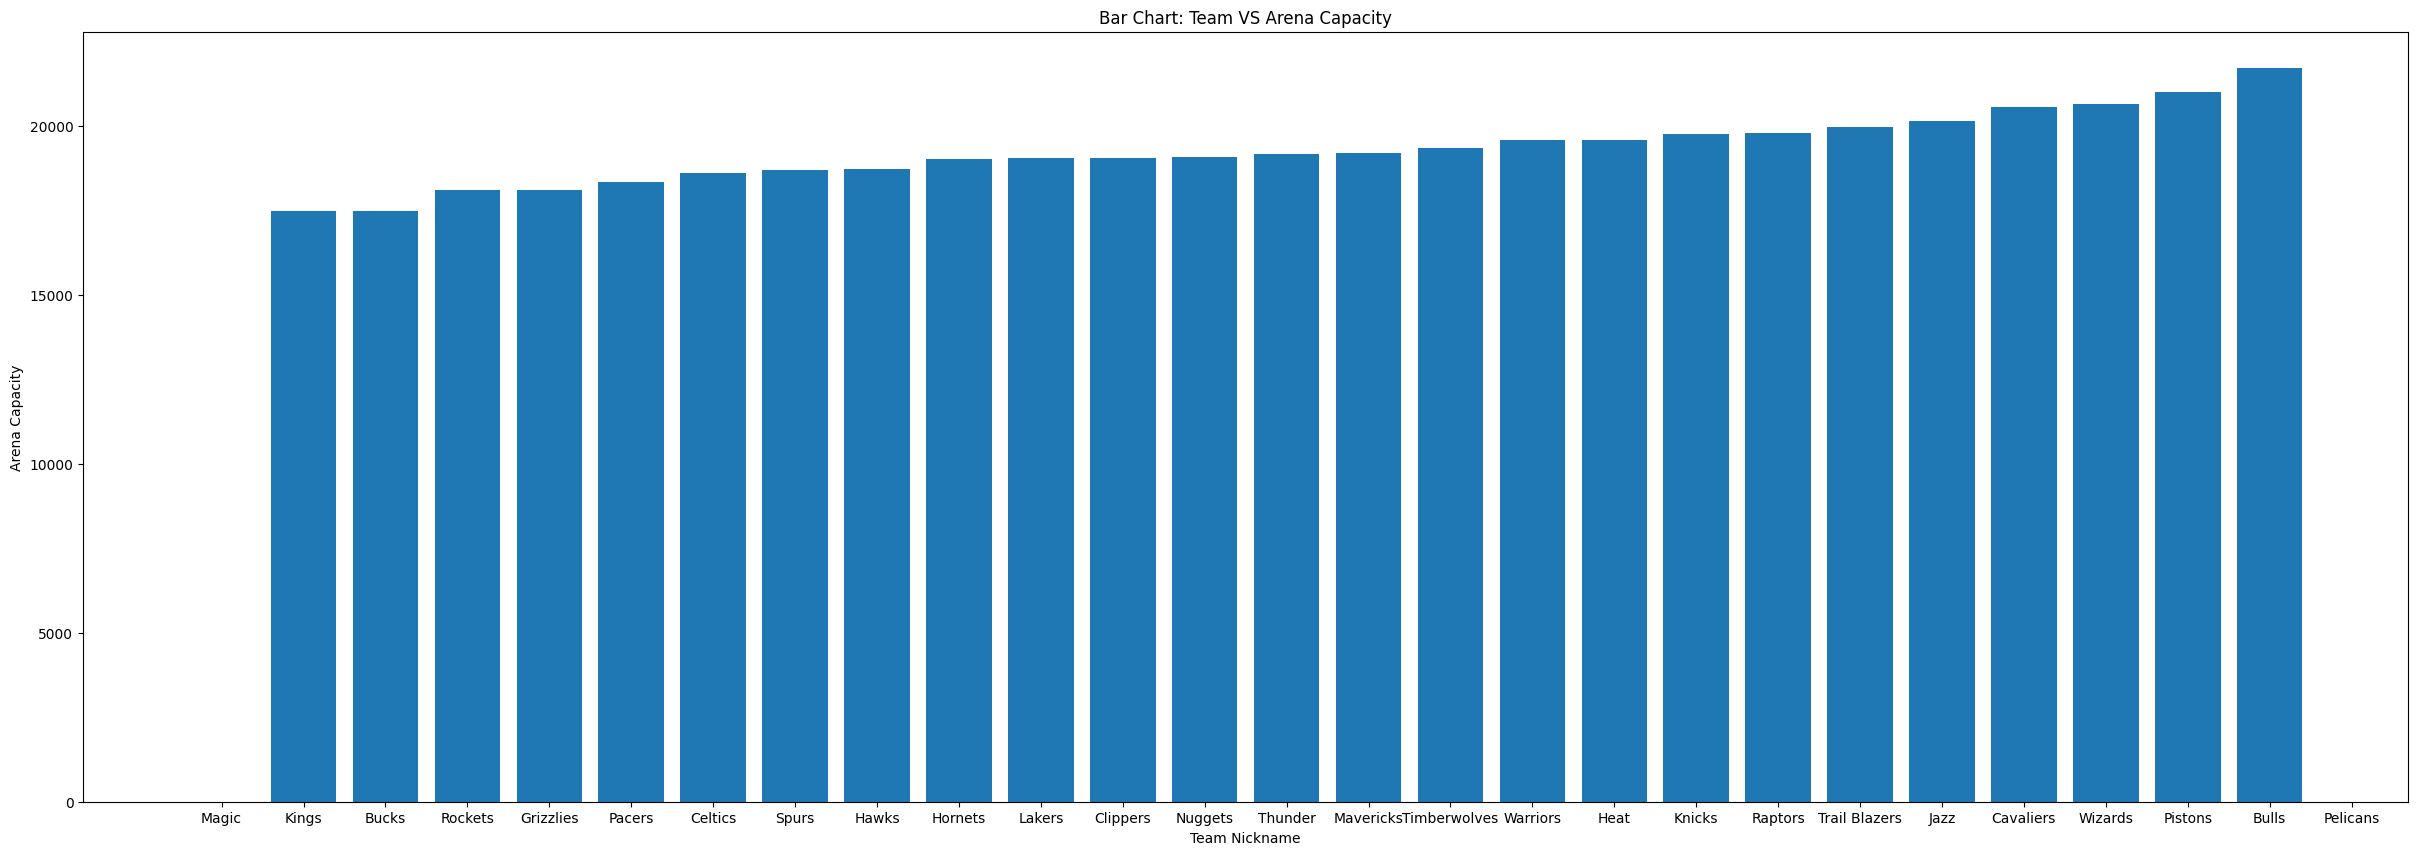

In [17]:
arena_strength = teams_df.copy().sort_values("ARENACAPACITY")
plt.figure(figsize=(30, 10))
plt.bar(arena_strength["NICKNAME"], arena_strength["ARENACAPACITY"])
plt.title('Bar Chart: Team VS Arena Capacity')
plt.xlabel('Team Nickname')
plt.ylabel('Arena Capacity')

Trend Observed: The bar chart presents a clear variability in arena capacities among different basketball teams, without indicating a uniform trend across the teams. Some teams boast significantly larger arena capacities, which could suggest a stronger home crowd presence.

Relevance to Research Question: In the context of exploring the "home team advantage," the differences in arena capacities could be crucial. Larger arenas might amplify the home crowd's impact on the players' performance, potentially influencing free throw percentages—a common measure of basketball efficiency. This visualization invites further investigation into whether a more substantial home crowd correlates with better home game performance, thereby motivating the question of how environmental factors contribute to home advantage. To establish relevance, subsequent analysis would need to integrate free throw percentages with arena capacity data while controlling for confounding variables.

### Possible follow-ups

Since city population is not provided in the data we have been given, a possible follow-up on our second research question might include researching how city population and arena size may affect the home team advantage.

## Categorical Visualization #2

Text(0, 0.5, 'FT_PCT_home')

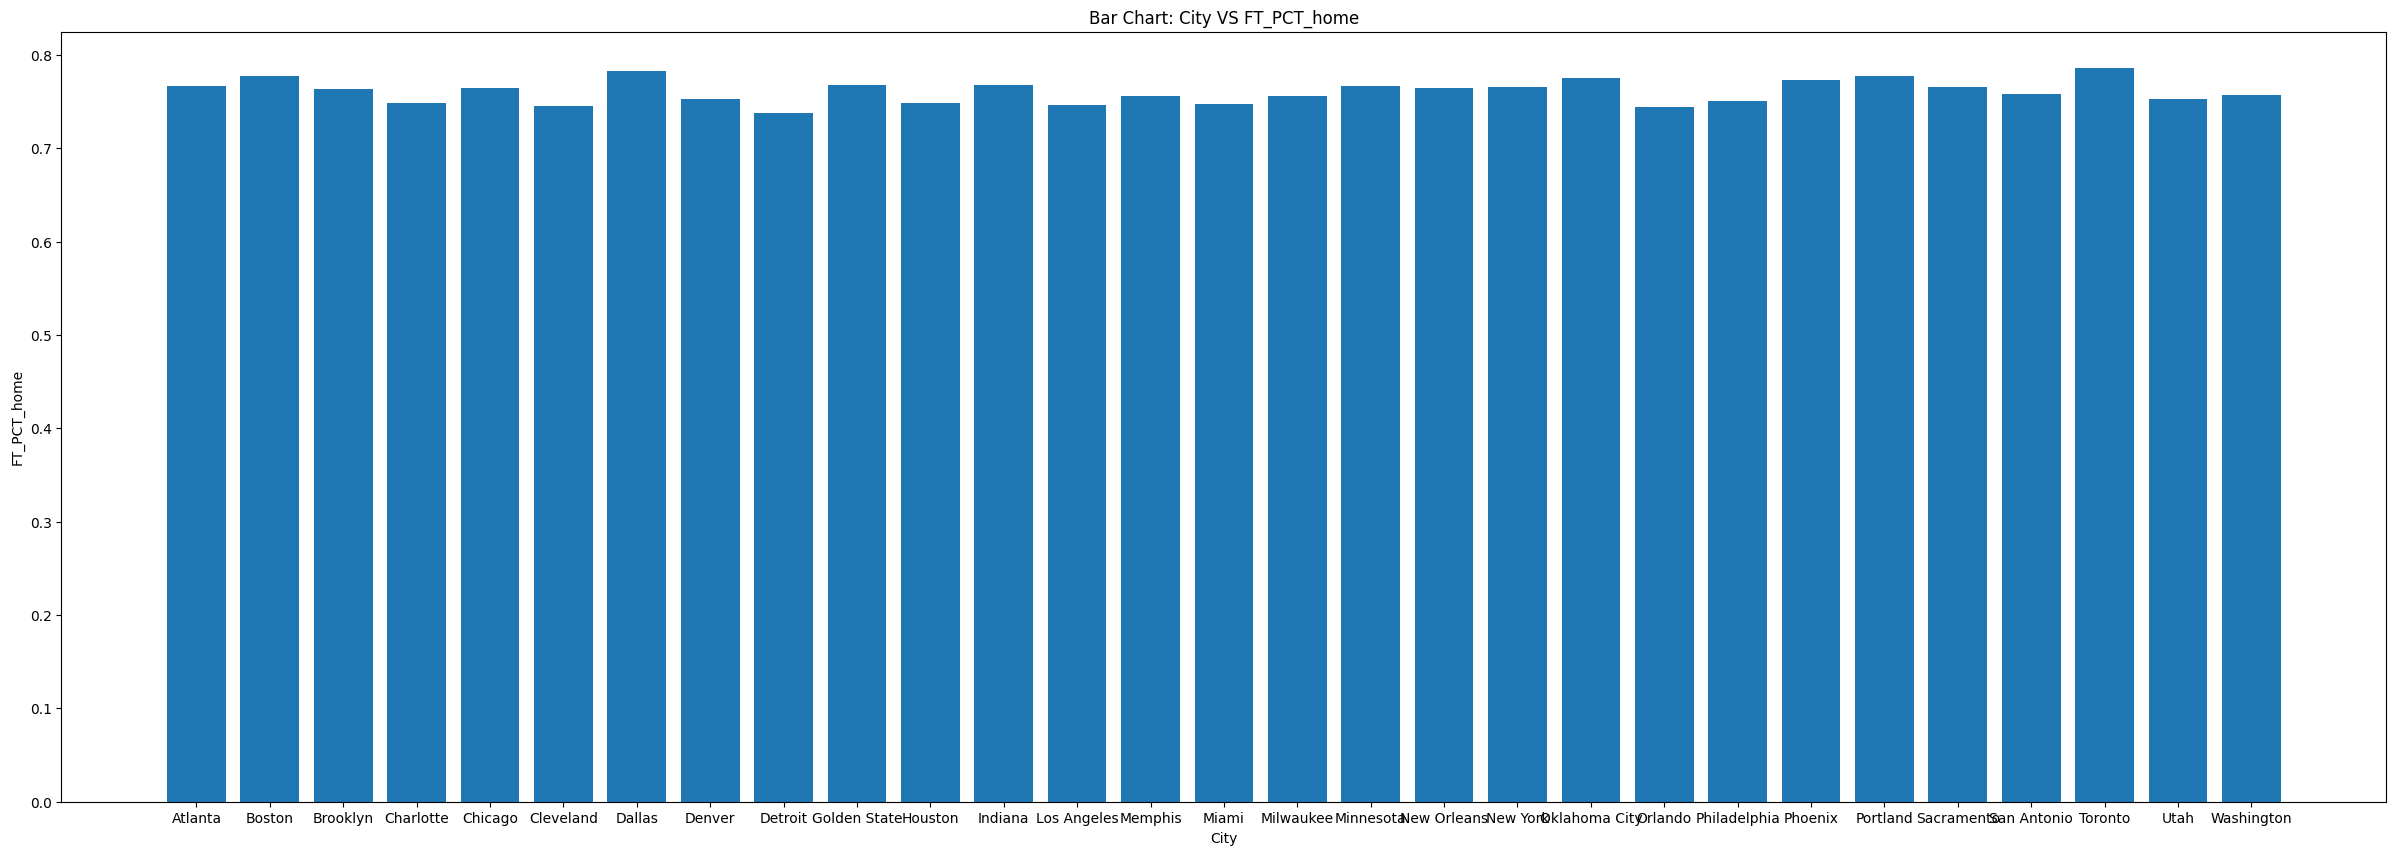

In [18]:
#------------------df copies--------------------
q2_teams_df = teams_df.copy()
q2_games_df = games_df.copy()

q2_games_df = q2_games_df.rename(columns={'HOME_TEAM_ID': 'TEAM_ID'})
q2_merged_df = pd.merge(q2_games_df, q2_teams_df, on='TEAM_ID', how='inner')
q2_visual_df = q2_merged_df.groupby(["CITY"]).mean().reset_index()

plt.figure(figsize=(30, 10))
plt.bar(q2_visual_df["CITY"], q2_visual_df["FT_PCT_home"])
plt.title('Bar Chart: City VS FT_PCT_home')
plt.xlabel('City')
plt.ylabel('FT_PCT_home')

We don't seem to observe any effect of the city on free throw percentage. There seems to be a roughly uniform distribution of free throw percentage among the different cities. 

The bar chart depicting free throw percentages across different cities shows uniformity in values, suggesting that city size, often considered a potential confounding factor, may not significantly influence the "home team advantage" in terms of free throw success. The similarity in percentages across cities implies that factors other than city size are more relevant to the research question. This lack of trend across city sizes can steer the research to focus more on the intrinsic qualities of teams and players in relation to home game performance, rather than external factors like the size of the city they represent.

# Option D: Causal Inference 

The "Home Team Advantage" (which we will call HTA) is the tendency of sports teams to play better on their home field than away. In this research question, we will examine the causal effects of a stripped-down version of HTA, which only includes having the home field, on the number of points NBA teams score in a game. Our thought is that by examining a more specific treatment effect, we may run into less confounders in our model.

### Assumptions

The major assumptions for this analysis are that the only factor in having the home field is the scheduling of games, and that the scheduling of games does not affect the points scored by the team for that game. This means that we can supposedly just use the SDO to estimate the effect of our selected treatment.

<img src="image-20231210-173111.png" width="" align="" />

First we will need to separate our data into games played by each team at home and away. 

In [19]:
home_avg_points = games_df.groupby(['HOME_TEAM_ID'], dropna=True).mean()
away_avg_points = games_df.groupby(['VISITOR_TEAM_ID'], dropna=True).mean()
home_avg_points[['PTS_home']]

,PTS_home
HOME_TEAM_ID,
1610612737,102.835414
1610612738,102.643083
1610612739,101.893362
1610612740,102.275618
1610612741,100.585475
1610612742,104.956858
1610612743,108.634902
1610612744,109.537611
1610612745,104.729911


In [20]:
# join home team averages with away team averages on the team ID
team_pts_avg_home_and_away = home_avg_points[['PTS_home']].join(away_avg_points[['PTS_away']])
team_pts_avg_home_and_away

,PTS_home,PTS_away
HOME_TEAM_ID,,
1610612737,102.835414,99.268590
1610612738,102.643083,100.910064
1610612739,101.893362,99.280584
1610612740,102.275618,99.706422
1610612741,100.585475,99.184332
1610612742,104.956858,101.331140
1610612743,108.634902,103.894967
1610612744,109.537611,105.496711
1610612745,104.729911,102.864653


Let us try using the SDO to get causal effect.

In [21]:
causal_effect_hf = team_pts_avg_home_and_away['PTS_home'].mean() - team_pts_avg_home_and_away['PTS_away'].mean()
causal_effect_hf

2.8156438873284486

Taking our assumptions into account, after calculating SDO on the effect of playing on the home field, we find that NBA teams score about 2.8 points higher on average when playing on the home field.

### Limitations and Follow ups

We were able to find a small causal effect of playing home field on the average score of teams. However, the Home Team Advantage is a much more complex phenomenon with many other factors, some of which may be confounders. A new research problem analyzing the effects of HTA and all of its factors on team score may follow a model similar to the following:

<img src="image-20231210-182620.png" width="" align="" />

Not all of the factors in this graph were available within our data; therefore, we decided to strip down the definition of our treatment to simplify the set of assumptions and adjustments we had to make. However, we believe it would be helpful to include more factors in a comprehensive investigation of HTA.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=c356f071-870a-41ea-8d56-76ef3453e31f' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>